In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

In [113]:
class linearSVM:
    
        
    def fit(self, dataset, learning_rate, epochs, regularization):
       # self.learning_rate = learning_rate

        size = len(dataset[0])-1
        
        w = np.ones(size) #1/size * 
        
        w_norms = []
        
        for i in range(epochs):
            #np.random.shuffle(dataset)
            for j in range(len(dataset)):
                learning_rate = 1/ (j + epochs)
                x = dataset[j,:-1]
                y = dataset[j,-1]
        #        print(x,y)
                loss = 1 - y * w.dot(x)
                if loss > 0:
                    gradient = w - regularization * y*x
                else:
                    gradient = w
                
                w = w - learning_rate * gradient
            
            w_norms.append(np.linalg.norm(w))
        
        return w, w_norms
        

        
def calculate_exact_w(dataset, regularization):
    # set initial w0
    size = len(dataset[0])-1
    w0 = np.ones(size) #1/size * 

    #lambda_1 = len(dataset) / (2 * regularization) 

    # define the constraint
    #con = {'type': 'ineq', 'fun': lambda w : 1/lambda_1 - np.linalg.norm(w)}

    # optimize target function using scipy.optimize.minimize
    res = minimize(target_func, x0=w0, args=(dataset,regularization), method='SLSQP') #, constraints=con

    return res.x


def target_func(w, data, regularization):
    f = (np.linalg.norm(w)**2) / 2 
    for i in range(len(data)):
        f += regularization / len(data) * max(0, 1 - data[i][-1] * np.dot(w, data[i][0:-1]))

    return f

In [114]:
#read data
data = pd.read_csv('toydata_tiny.csv').to_numpy()

#add one to each feature vector
#data = np.insert(data, obj = 4, values = np.ones(len(data)), axis = 1)

# shuffle along the first axis of array
#np.random.shuffle(data)

In [115]:
mySVM = linearSVM()
regularization = 100
learning_rate = 0.1
epochs = 10000
w, w_norms = mySVM.fit(data,learning_rate,epochs,regularization)
print(w)
print(np.linalg.norm(w))

w_exact = calculate_exact_w(data,regularization)
print(w_exact)
print(np.linalg.norm(w_exact))


[ 1.21520291 -1.88412096]
2.242014695782624
[ 1.00006963 -1.66177827]
1.9394964009060593


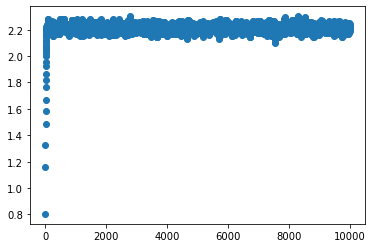

In [116]:
xs = range(epochs)
plt.scatter(xs, w_norms)
#plt.xlim([0,50])
plt.show()

In [68]:
data

array([[ 8.81832916,  2.46629509,  1.        ],
       [ 4.11406614,  4.78290812, -1.        ],
       [ 2.35897576,  1.88002039, -1.        ],
       [11.64072755,  5.5441185 ,  1.        ],
       [ 9.4283826 ,  4.04075559,  1.        ],
       [ 8.32779364,  3.39371615,  1.        ],
       [ 5.01977546,  2.72404388,  1.        ],
       [ 7.90775256,  3.25419115,  1.        ],
       [ 3.96817468,  3.87033686, -1.        ],
       [11.17609744,  5.39319312,  1.        ],
       [ 3.5855031 ,  2.76232469, -1.        ],
       [ 9.58150068,  3.69355988,  1.        ],
       [ 8.85406633,  4.04077246,  1.        ],
       [ 9.006     ,  4.17690646,  1.        ],
       [ 3.13616066,  4.98110414, -1.        ],
       [ 8.01490126,  4.34271338,  1.        ],
       [ 3.24114703,  2.31961474, -1.        ],
       [ 0.80209679,  2.56915786, -1.        ],
       [ 4.21942827,  4.44621598, -1.        ],
       [ 6.80557518,  2.24505336,  1.        ],
       [ 3.15303689,  2.38085702, -1.   